In [ ]:
import os
import numpy as np
import matplotlib
import torch
# !pip install mat73
# import mat73
import matplotlib.pyplot as plt
import csv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from torchvision import transforms, utils
import time
import pandas as pd
import scipy.io
import sklearn.metrics
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

from scipy import signal

from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import LeaveOneGroupOut






In [ ]:
Folder='personal_model_vit'
parent_dir = r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+Folder+'/'
path1 = os.path.join(parent_dir, 'cm_fig')
os.makedirs(path1, exist_ok = True) 
path1 = os.path.join(parent_dir, 'result_all')
os.makedirs(path1, exist_ok = True) 

def plotfigFullClass(cm,acc,tle,saveN):

    parent_dir = r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+Folder+'/'
    path1 = os.path.join(parent_dir, 'cm_fig')
    os.makedirs(path1, exist_ok = True) 
    path1 = os.path.join(parent_dir, 'result_all')
    os.makedirs(path1, exist_ok = True) 




    labelNum=str(1)  #labelling method 1,2,3,4
    size=15
    name1=["R", "G","G*2","P1","P1*2","P2","P2*2","P23","P23*2","P4","P4*2","sG","sF","sP1","sP2","sP23","sP4","U","U*2","D","D*2","sU","sD"]
    name2=name1
    w=20 #fig size 1      change when label num change
    h=22   #fig size 2
    
    # true_num=0
    # for i in range (len(cm)):
    #   true_num=true_num+ cm[i,i]
    # acc=true_num/np.sum(cm)   
    
    df_cm = pd.DataFrame(cm, index=name1, columns=name2)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure()
    sn.set(font_scale=1.2)
    mask = np.zeros_like(df_cm)
    mask[np.where(cm==0)] = True
    
    sn.heatmap(df_cm, cmap="YlGnBu",fmt=".2f",vmin=0, vmax=1.0,annot=True,mask=mask,square=True,cbar=False,annot_kws={"size": size,'fontsize':15})
 
    s01=' Acc={n:.3f}'.format(n=acc)
    #plt.text(a,b,s01,fontsize=size)
    
    
    plt.title(tle+s01)

    figure = plt.gcf()
    figure.set_size_inches(w, h)
    
    plt.savefig(parent_dir+r"cm_fig/"+saveN+".png", dpi=300)




In [ ]:
# load saved tested results for all participants



from google.colab import drive
drive.mount('/content/drive')
in_ch=48
k=7
m1='Kfold'
m2='groupKfold'
m3='group'
ExpVer_list=['2_5','2_9','2_10','2_11','2_13','2_14','2_15','2_17'] # multi_participant dataset per8 
ExpVer_list=['2_1','2_16','2_19'] # sensor setup vaiation 
#ExpVer_list=['2_24'] # sensor position vaiation
def loadResult(m):
  cm_norm_all_per=[]
  acc_all_per=[]
  test_y_all_per=[]
  feature_listName=["stft","stft2","cwt","cwt2","cwt3"]
  SaveName='ch'+str(in_ch)+'_'+str(k)+m
  for per in range(len(ExpVer_list)):
    Path=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer_list[per]+r"/result/npyFile/vit_"+SaveName+"_ensemble5.npz"
    data=np.load(Path,allow_pickle=True)
    cm_norm=data['cm_norm']
    #acc_all=data['acc_all']
    acc=data['acc']
    y=data['y']
    

    cm_norm_all_per.append(cm_norm)
    acc_all_per.append(acc)
    test_y_all_per.append(y)
    
  acc_all_per=np.array(acc_all_per)

  cm_norm_all_per=np.array(cm_norm_all_per)
  
   
  return cm_norm_all_per,acc_all_per,test_y_all_per


mVer=m1
cm_norm_all,acc_all,test_y_all=loadResult(mVer)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:



## output ensemble result and output the final max accuracy, the highest or ensemble 

def ensemble_y(test_y_all):
  test_y1=test_y_all[0]
  y_ensemble=np.zeros([np.size(test_y1,axis=1),])
  for i in range(np.size(test_y1,axis=1)):
    
    list=[]
    for j in range(len(test_y_all)):

      list.append(test_y_all[j][1,i])  ## append different feat ver. 
    
    (unique, counts) = np.unique(list, return_counts=True)

    label=unique[np.argmax(counts)]
    y_ensemble[i]=label


  cm_norm=confusion_matrix(test_y1[0,:], y_ensemble,normalize='true')
  acc=accuracy_score(test_y1[0,:], y_ensemble)
  
   

  return cm_norm,acc,y_ensemble

cm_norm_en=[]
y_ensemble_en=[]
acc_en=[]
cm_norm_max=[]

acc_max=[]
max_Featver=[]  
for i in range(len(ExpVer_list)):
  test_y_per=test_y_all[i]

  cm_t,acc_t,y_ensemble_t=ensemble_y(test_y_per)
  cm_norm_en.append(cm_t)
  acc_en.append(acc_t)
  y_ensemble_en.append(y_ensemble_t)
  
  feature_listName=["stf2","stft2","cwt","cwt2","cwt3",'en']
  
  acc_comp=np.append(acc_all[i,:],acc_t)

  cm_comp=[cm_norm_all[i][0],cm_norm_all[i][1],cm_norm_all[i][2],cm_norm_all[i][3],cm_norm_all[i][4],cm_norm_en[i]]
  acc_max.append(acc_comp[np.argmax(acc_comp)])
  cm_norm_max.append(cm_comp[np.argmax(acc_comp)])
  max_Featver.append(feature_listName[np.argmax(acc_comp)])



Folder='personal_model_vit/'
SaveName='result_all_max_'+str(k)+mVer
SaveName='result_all_max_'+str(k)+mVer+"sensorVar"
np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/"+Folder+"result_all/"+SaveName+".npz",\
                    cm_norm_all=cm_norm_all,acc_all=acc_all,\
                    
                   acc_max=acc_max,cm_norm_max=cm_norm_max,max_Featver=max_Featver)
    

In [ ]:
## fig cm mean 
cm_norm_max=np.array(cm_norm_max)
cm_norm_max_mean=np.mean(cm_norm_max,axis=0)
cm_norm_max_mean_th=np.where(cm_norm_max_mean > 0.007, cm_norm_max_mean, 0)
print(cm_norm_max_mean_th)
acc_max_mean=np.mean(acc_max)#Accuracy on all participants by transfer learning using 1/5 new data
plotfigFullClass(cm_norm_max_mean_th,acc_max_mean,'Result on all participants using personal trained model by '+ mVer +' k='+ str(k),'all')


[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.97826087 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.02173913 0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.

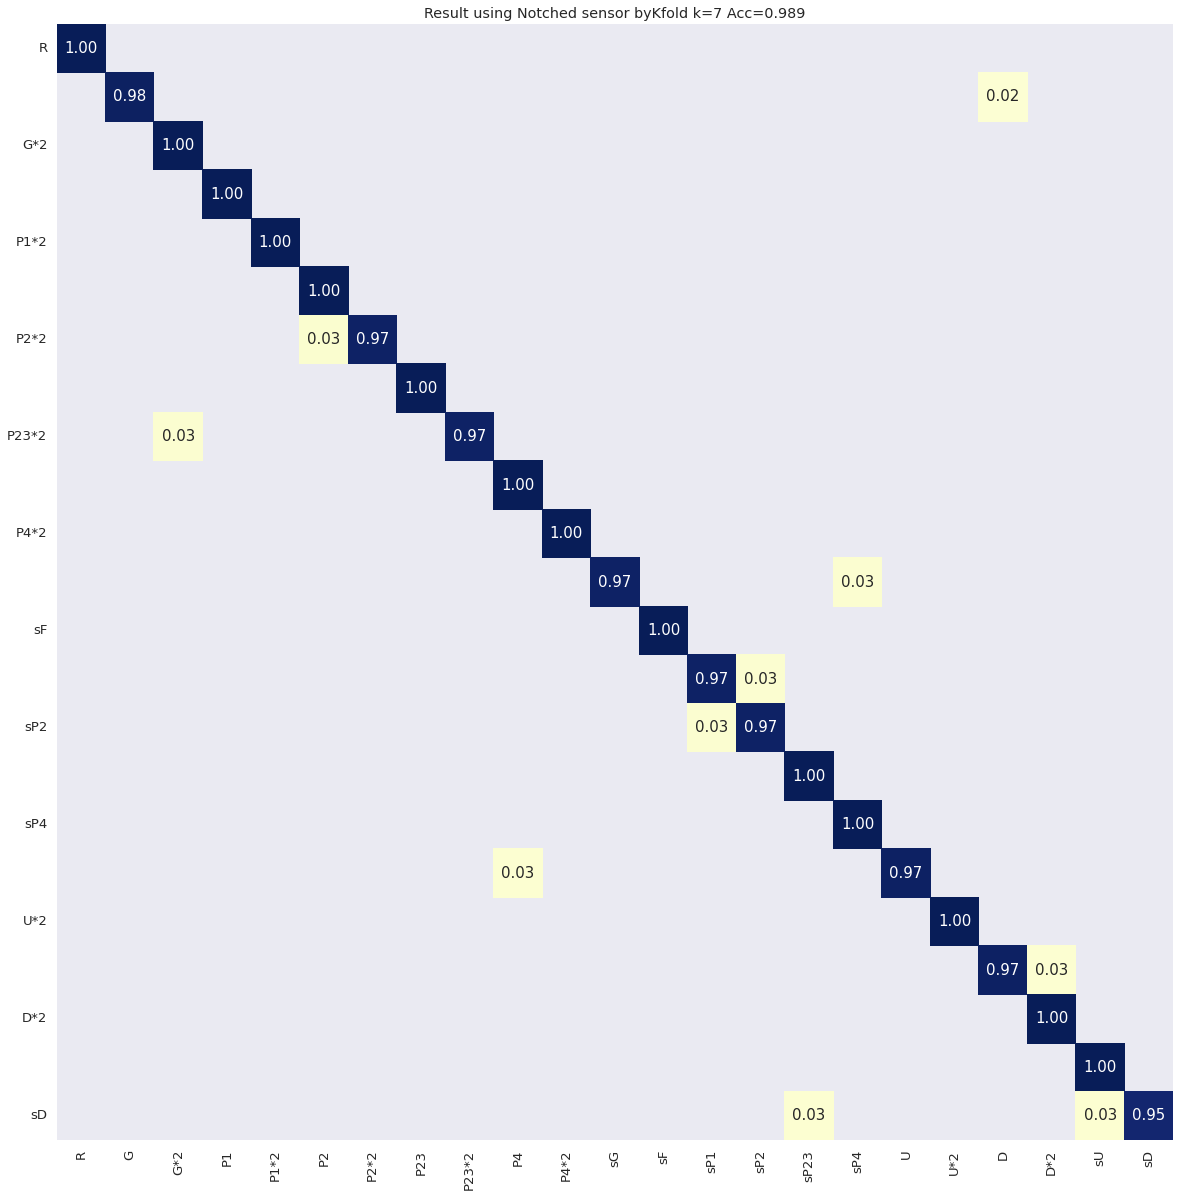

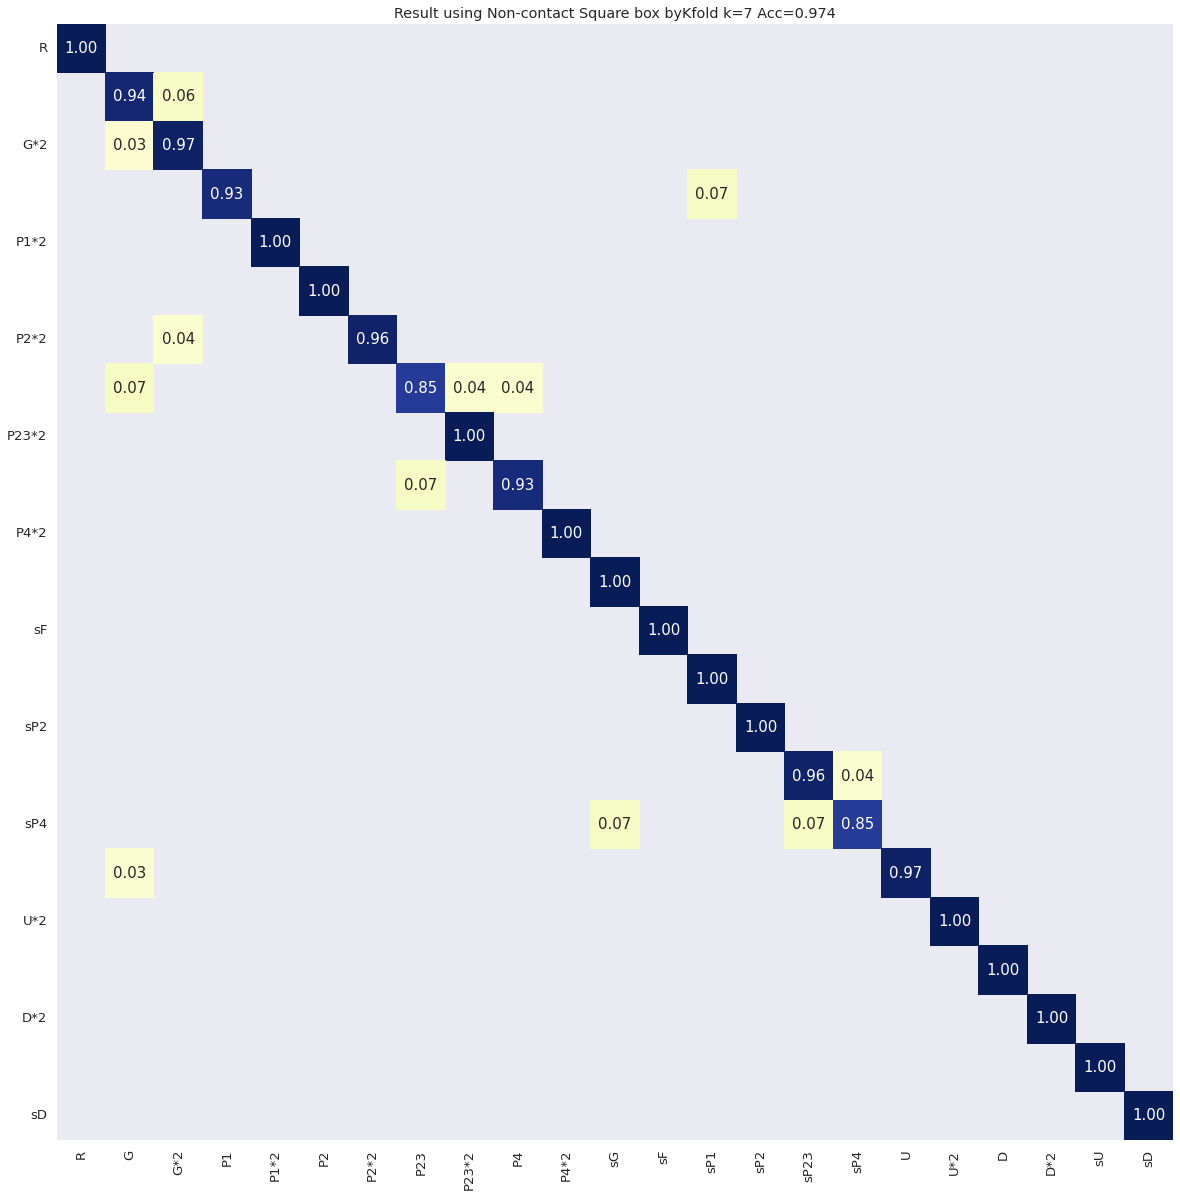

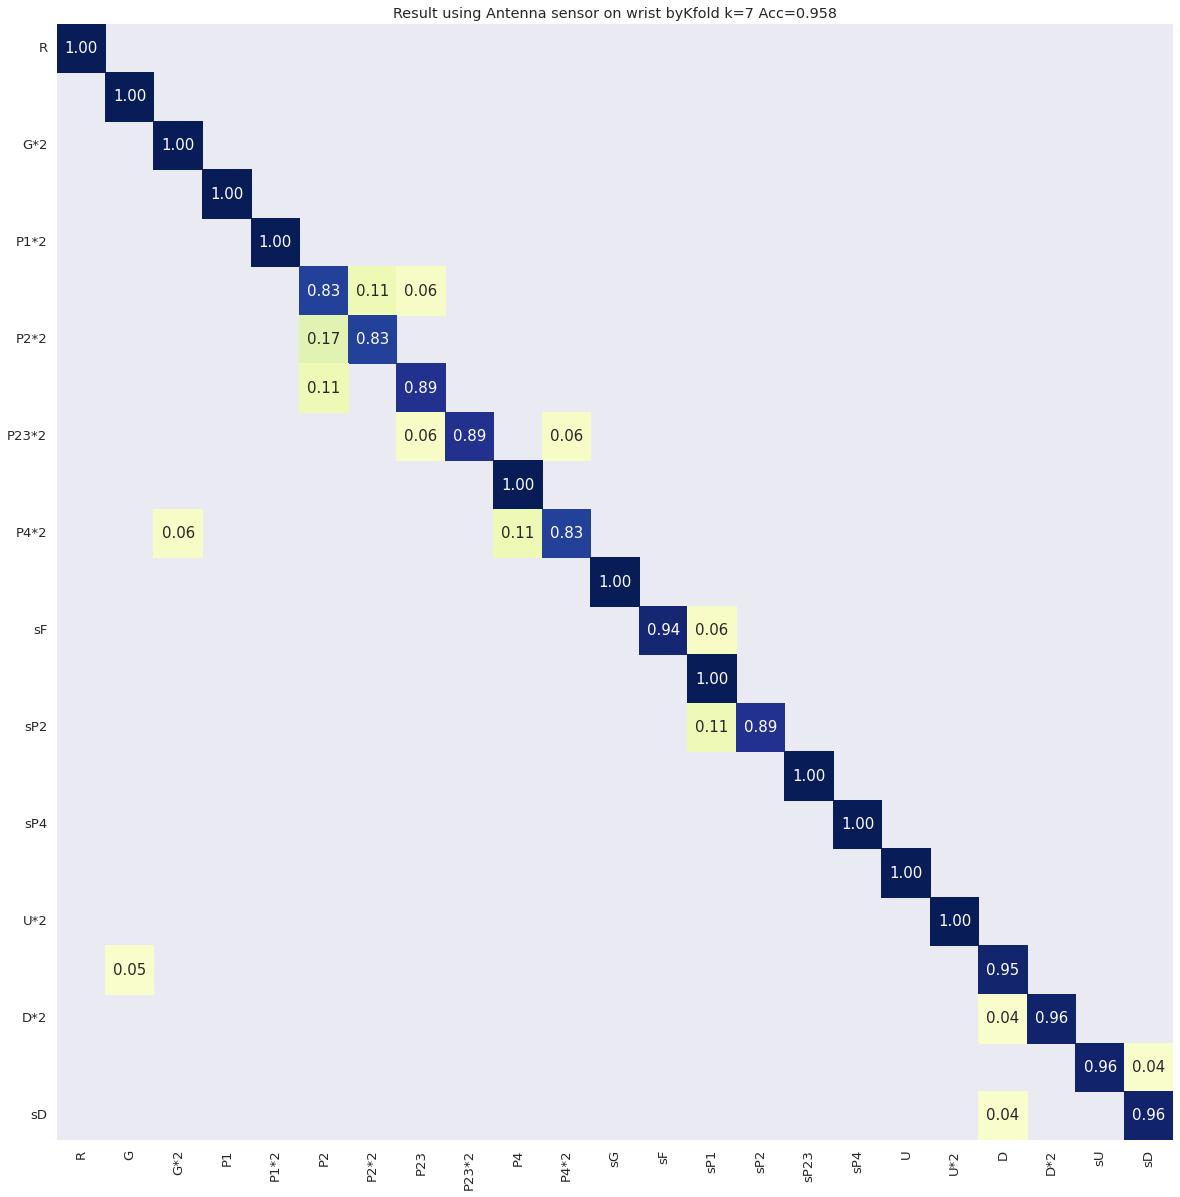

In [ ]:
## fig cm  individual for different sensor modality 
SensorN=['Notched sensor','Non-contact Square box','Antenna sensor on wrist']
SaveN=['Notched','Square','wristPos']
for i in range(len(ExpVer_list)):
  cm_norm_max=np.array(cm_norm_max)
  cm_norm_max_mean=cm_norm_max[i]
  cm_norm_max_mean_th=np.where(cm_norm_max_mean > 0.01, cm_norm_max_mean, 0)
  print(cm_norm_max_mean_th)
  acc_max_mean=acc_max[i]#Accuracy on all participants by transfer learning using 1/5 new data
  plotfigFullClass(cm_norm_max_mean_th,acc_max_mean,'Result using '+SensorN[i]+' by' + mVer +' k='+ str(k),SaveN[i])


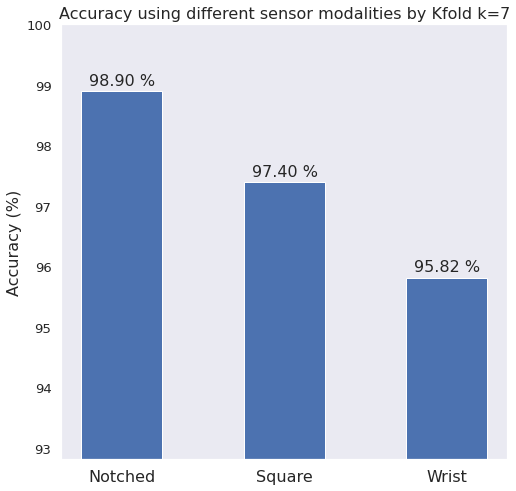

In [ ]:
# plot one featVer result one CV method 
SensorN=('Notched sensor','Non-contact Square box','Antenna sensor on wrist')
SaveN=['Notched','Square','Wrist']

k=7
FeatVer=3
feature_listName=["stft","stft2","cwt","cwt2","cwt3"]


acc1_all_per=np.array(acc_max)

saveFigPath=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+Folder+'/'


bar_width = 0.5
sz=16
fig, ax = plt.subplots(figsize=(8, 8))
x = np.arange(len(acc1_all_per))+1 

# Note we add the `width` parameter now which sets the width of each bar.
b1 = ax.bar(x, acc1_all_per*100,width=bar_width,label=feature_listName[FeatVer])



plt.ylim(np.amin(acc1_all_per)*100-3, 100)
plt.grid(False)
axis_font={'fontname':'Times New Roman', 'size':str(sz)}

plt.xticks(x,SaveN,fontsize=str(sz))
plt.ylabel('Accuracy (%)',axis_font)

plt.title('Accuracy using different sensor modalities by ' + mVer +' k='+ str(k),axis_font)

for i in range(len(x)):
  s='{n:.2f} %'.format(n=acc1_all_per[i]*100)
  plt.text(x[i]-0.2,acc1_all_per[i]*100+0.1,s,axis_font)



tleSave=str(k)+mVer+'_ensemble_'+'sensorVar'

plt.savefig(saveFigPath+r"fig_all/"+tleSave+".png", dpi=300)